<div align="center">

# Vehicule's License Plate Detection

 </div>

Vehicle License plate detection and recognition is a well-known challenge that has been tackled by many computer-vision labs and companies. However, each country has its own specific license plate formats. This challenge is targeting regular Tunisian license plates. The data provided for this challenge is composed of two datasets:
A set of vehicle images (900 images) taken from the internet and annotated manually. The annotations are the coordinates of the bounding box containing the license plate.
A set of license plate images (900 images) where the annotations are the text written in the license plate.

In [1]:
import  tensorflow as tf
import pandas as pd
import numpy as np



from project.image_preprocess.data_aug.data_aug import *
from project.image_preprocess.data_aug.bbox_util import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import figure

import random

from PIL import Image

## Exploratory Data Analysis

First, let's load the training the data and explore the shape of the images.

In [2]:
def load_data(path):
    """
    loads the labels and their images
    
    :path path to the data directory
    """
    # L
    df_target = pd.read_csv(f'{path}/train_target.csv')
    # load the images in the same order of the target DF
    images = []
    images_metadata = {
        'width':[],
        'height':[]
    }
    for image in df_target['img_id']:
        images.append(np.array(Image.open(f'{path}/train/{image}')))
        # Getting information about the images shape 
        images_metadata['height'].append(images[-1].shape[1])
        images_metadata['width'].append(images[-1].shape[0])
    df_target['heights'] = images_metadata['height']
    df_target['width'] = images_metadata['width']
    return images, df_target

images, targets = load_data('./data')

Text(0, 0.5, 'Count')

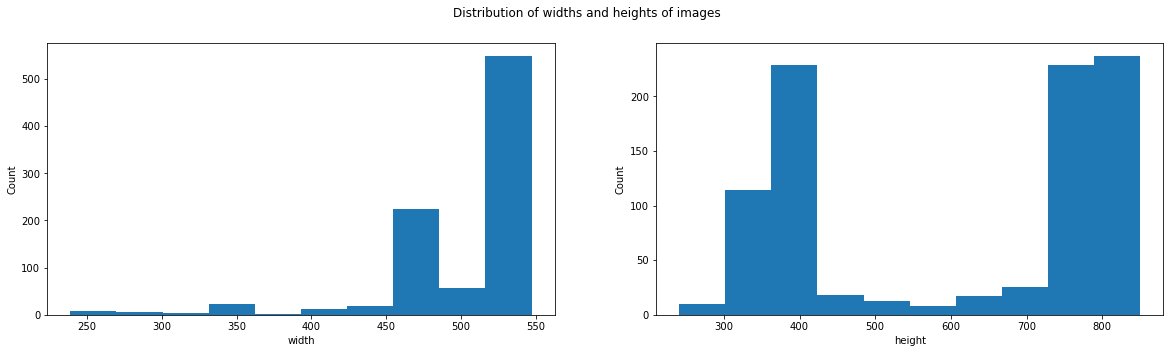

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Distribution of widths and heights of images')
axs[0].hist(targets['width'])
axs[0].set_xlabel('width')
axs[0].set_ylabel('Count')
axs[1].hist(targets['heights'])
axs[1].set_xlabel('height')
axs[1].set_ylabel('Count')

The plots above show that the images are not of the same size and we should fix problem as the NN will only accept a fixed shape as input

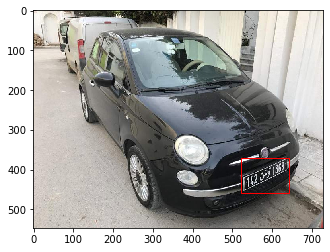

In [4]:
def plot_image(image, x_min, y_min, x_max, y_max):
    """
    Plots the image of the car with a bounding box around the licence plate
    
    :image: the image of the car
    :x_min : the minimum x position of the box
    :y_min : the minimum y position of the box
    :x_max : the maximum x position of the box
    :y_max : the maximum y position of the box
    """
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(image)
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
    

def plot_random_image(images, targets, index=None):
    """
    Plots a random image (or the image at the position index)
    """
    if index is None:
        index = random.randint(0, len(images))
    y_min, x_min, y_max, x_max = targets.iloc[index][['ymin', 'xmin', 'ymax', 'xmax' ]]
    plot_image(images[index], x_min, y_min, x_max, y_max)
    
    
plot_random_image(images, targets)

## Data Pre-processing and Augmentation

In [7]:
# Change all images to the same shape

def reshape(image, plate_position, new_size=224):
    img_, bboxes_ = Resize(new_size)(image.copy(), plate_position.copy())
    return img_, bboxes_
    

def reshape_images(images,target_df, new_shape=224):
    new_images =[]
    new_position = []
    
    for i in range(len(images)):
        plate_position = target_df.loc[i, ['xmin','ymin', 'xmax', 'ymax' ]].values.reshape(1,-1)
        resized_image, new_box = reshape(images[i], plate_position, new_shape)
        new_images.append(resized_image)
        new_position.append([new_box ])

    new_targets = pd.DataFrame(np.array(new_position).reshape(-1,4))

    new_targets.columns = ['xmin', 'ymin', 'xmax', 'ymax' ]
    new_targets ['img_id'] = target_df['img_id']
    return new_images, new_targets
    

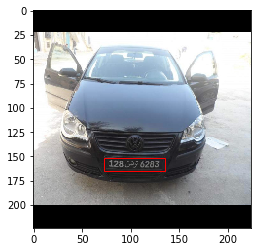

In [8]:
new_images, new_targets = reshape_images(images, targets)
plot_random_image(new_images, new_targets)

In [9]:
img = new_images[10]
bboxes = new_targets.iloc[10][[ 'xmin', 'ymin',  'xmax', 'ymax']].values.reshape(1,-1)

img_1, bboxes_1 = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
img_2, bboxes_2 = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
img_3, bboxes_3 = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
img_4, bboxes_4 = RandomRotate(20)(img.copy(), bboxes.copy())
img_5, bboxes_5 =  RandomShear(0.2)(img.copy(), bboxes.copy())
img_6, bboxes_6 = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())

seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_7, bboxes_7 = seq(img.copy(), bboxes.copy())

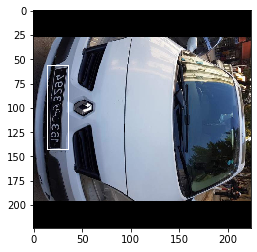

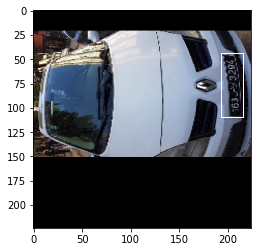

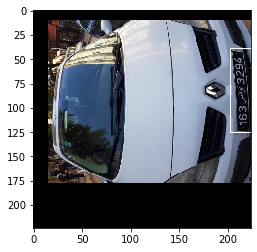

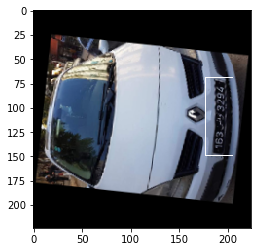

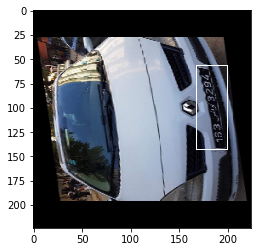

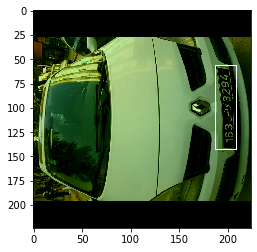

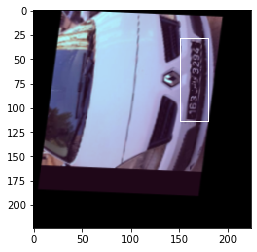

In [10]:
images_test = [(img_1, bboxes_1), 
               (img_2, bboxes_2), 
               (img_3, bboxes_3), 
               (img_4, bboxes_4), 
               (img_5, bboxes_5), 
               (img_6, bboxes_6), 
               (img_7, bboxes_7), ]

for im, box in images_test:
    plotted_img = draw_rect(im, box)
    plt.imshow(plotted_img)
    plt.show()


## Plate position Detection Model

### Model Definition

#### Pre-trained model

#### Custom CNN

In [125]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense


model = Sequential([
    Conv2D(5, 7, activation='relu', input_shape=(224,224,3)),
    Conv2D(10, 3, activation='relu'),
    Dropout(.2),
    Flatten(),
    Dense(128),
    Dense(4, activation='relu')
])

image = tf.random.normal((1,224,224,3))
model(image)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.17542803, 0.6921811 , 0.70468456, 0.4118315 ]], dtype=float32)>

### Model Training

### Model Evaluation

## OCR for text recognition